In [876]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [877]:
%cd gdrive/MyDrive/comptech

[Errno 2] No such file or directory: 'gdrive/MyDrive/comptech'
/content/gdrive/MyDrive/comptech


In [878]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta
from tqdm import tqdm
import warnings
import gc

import holidays

import lightgbm as lgb

from sklearn.base import BaseEstimator
from sklearn.metrics import mean_absolute_percentage_error

In [879]:
tqdm.pandas()
warnings.simplefilter('ignore')

In [880]:
%pylab inline
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(16, 6)})

Populating the interactive namespace from numpy and matplotlib


In [881]:
ORDERS_PATH = 'orders.csv'
DELAYS_PATH = 'partners_delays.csv'
SEED = 2021
DATE_TEST_SPLIT = pd.to_datetime('2021-11-16')
PREV_COLS_CNT = 30
NEXT_COLS_CNT = 7
EPS = 10e-7

### Загрузка данных

In [882]:
orders = pd.read_csv(ORDERS_PATH, parse_dates=['date'])
delays = pd.read_csv(DELAYS_PATH, parse_dates=['dttm'])

In [883]:
orders.head()

,delivery_area_id,date,orders_cnt
0,0,2021-04-01 10:00:00,9
1,0,2021-04-01 11:00:00,1
2,0,2021-04-01 13:00:00,1
3,0,2021-04-01 14:00:00,1
4,0,2021-04-01 15:00:00,2


In [884]:
delays.head()

,delivery_area_id,dttm,partners_cnt,delay_rate
0,0,2021-04-01 09:00:00,3.0,0.000000
1,0,2021-04-01 10:00:00,4.0,0.111111
2,0,2021-04-01 11:00:00,4.0,0.000000
3,0,2021-04-01 12:00:00,4.0,0.000000
4,0,2021-04-01 13:00:00,1.0,0.000000


#### Праздничные и выходные дни

In [885]:
dayoffs = [
  '2021.01.01','2021.01.02','2021.01.03','2021.01.04','2021.01.05','2021.01.06','2021.01.07','2021.01.08','2021.01.09','2021.01.10','2021.01.16','2021.01.17','2021.01.23',
  '2021.01.24','2021.01.30','2021.01.31','2021.02.06','2021.02.07','2021.02.13','2021.02.14','2021.02.21','2021.02.22','2021.02.23','2021.02.27','2021.02.28','2021.03.06',
  '2021.03.07','2021.03.08','2021.03.13','2021.03.14','2021.03.20','2021.03.21','2021.03.27','2021.03.28','2021.04.03','2021.04.04','2021.04.10','2021.04.11','2021.04.17',
  '2021.04.18','2021.04.24','2021.04.25','2021.05.01','2021.05.02','2021.05.03','2021.05.04','2021.05.05','2021.05.06','2021.05.07','2021.05.08','2021.05.09','2021.05.10',
  '2021.05.15','2021.05.16','2021.05.22','2021.05.23','2021.05.29','2021.05.30','2021.06.05','2021.06.06','2021.06.12','2021.06.13','2021.06.14','2021.06.19','2021.06.20',
  '2021.06.26','2021.06.27','2021.07.03','2021.07.04','2021.07.10','2021.07.11','2021.07.17','2021.07.18','2021.07.24','2021.07.25','2021.07.31','2021.08.01','2021.08.07',
  '2021.08.08','2021.08.14','2021.08.15','2021.08.21','2021.08.22','2021.08.28','2021.08.29','2021.09.04','2021.09.05','2021.09.11','2021.09.12','2021.09.18','2021.09.19',
  '2021.09.25','2021.09.26','2021.10.02','2021.10.03','2021.10.09','2021.10.10','2021.10.16','2021.10.17','2021.10.23','2021.10.24','2021.10.30','2021.10.31','2021.11.01',
  '2021.11.02','2021.11.03','2021.11.04','2021.11.05','2021.11.06','2021.11.07','2021.11.13','2021.11.14','2021.11.20','2021.11.21','2021.11.27','2021.11.28','2021.12.04',
  '2021.12.05','2021.12.11','2021.12.12','2021.12.18','2021.12.19','2021.12.25','2021.12.26','2021.12.31'
]
dayoffs = [pd.to_datetime(day) for day in dayoffs]

In [886]:
holidays_dict = holidays.RU(years=(2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index').reset_index()
df_holidays.columns = ['ds', 'holiday']
df_holidays['ds'] = pd.to_datetime(df_holidays['ds'])
df_holidays.head()

,ds,holiday
0,2021-01-01,Новый год
1,2021-01-02,Новый год
2,2021-01-03,Новый год
3,2021-01-04,Новый год
4,2021-01-05,Новый год


#### Описательные статистики

In [887]:
delays.describe()

,delivery_area_id,partners_cnt,delay_rate
count,1.247471e+06,1.247471e+06,1.247471e+06
mean,2.698000e+02,2.026328e+00,2.831878e-02
std,1.765557e+02,1.671793e+00,1.009584e-01
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.050000e+02,1.000000e+00,0.000000e+00
50%,2.650000e+02,1.000000e+00,0.000000e+00
75%,4.210000e+02,2.000000e+00,0.000000e+00
max,5.920000e+02,6.000000e+01,1.000000e+00


In [888]:
orders.describe()

,delivery_area_id,orders_cnt
count,884856.000000,884856.000000
mean,259.623341,3.790038
std,178.580787,3.808991
min,0.000000,1.000000
25%,88.000000,1.000000
50%,253.000000,3.000000
75%,416.000000,5.000000
max,592.000000,120.000000


#### Разбиение даты на составляющие

In [889]:
def split_date_time(data):
  data['dttm'] = pd.to_datetime(data['dttm'])
  data['year'] = data['dttm'].dt.year
  data['month'] = data['dttm'].dt.month
  data['week'] = data['dttm'].dt.week
  data['dayofweek'] = data['dttm'].dt.dayofweek
  #data['time'] = data['dttm'].dt.time
  #data['hour'] = data['dttm'].dt.hour
  #data['hour_cos'] = np.cos(2 * math.pi * data['hour'] / 24)
  #data['hour_sin'] = np.sin(2 * math.pi * data['hour'] / 24)
  return data

#### Группировка по дате

In [890]:
orders['date'] = orders['date'].dt.date
orders = orders.groupby(['delivery_area_id', 'date']).count()['orders_cnt'].reset_index()

In [891]:
orders['dttm'] = orders['date']
delays = split_date_time(delays)
orders = split_date_time(orders)

#### Добавление 0 для отсутствующих значений

In [892]:
if 0:
  dates = pd.date_range(orders.date.min(), orders.date.max() + timedelta(days=1), freq='H').tolist()
  dates = [date for date in dates if date.hour > 9 and date.hour < 20]

In [893]:
if 0:
  dict_list = []
  for delivery_area in tqdm(orders['delivery_area_id'].unique(), position=0, leave=True):
    for date in dates:
        dict_list.append({
          'delivery_area_id': delivery_area,
          'date': date,
          'orders_cnt': 0
        })

  zeros_df = pd.DataFrame(dict_list)
  print(zeros_df.shape)
  zeros_df.head()

In [894]:
if 0:
  intersection = pd.merge(zeros_df.reset_index(), orders, how='inner', on=['date', 'delivery_area_id'])['index']
  distinction = zeros_df.drop(zeros_df.iloc[intersection.values].index)
  assert distinction.shape[0] == zeros_df.shape[0] - intersection.shape[0]

In [895]:
if 0:
  orders = pd.concat([orders, distinction], ignore_index=True)
  orders = orders.sort_values(by=['delivery_area_id', 'date'])
  orders

### Визуализации

#### Среднее опоздание по дням

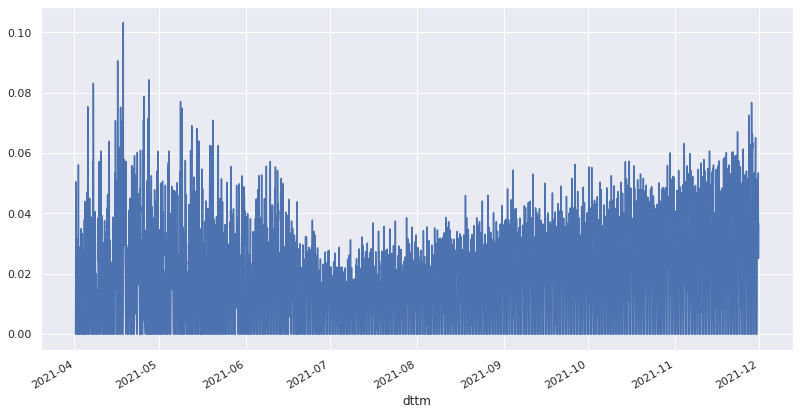

In [896]:
delays.groupby('dttm').mean()['delay_rate'].plot(figsize=(12, 7), grid=True)

#### Среднее опоздание по времени дня

In [897]:
#delays.groupby('hour').mean()['delay_rate'].plot(figsize=(12, 7), grid=True)

#### Количество заказов по дням

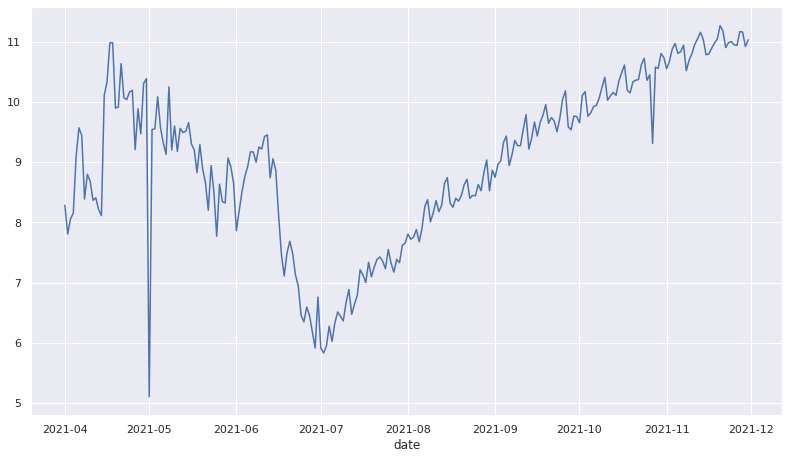

In [898]:
orders.groupby('date').mean()['orders_cnt'].plot(figsize=(12, 7), grid=True)

#### Количество заказов по времени дня

In [899]:
#orders.groupby('hour').mean()['orders_cnt'].plot(figsize=(12, 7), grid=True)

#### orders_cnt для разных delivery_area_id

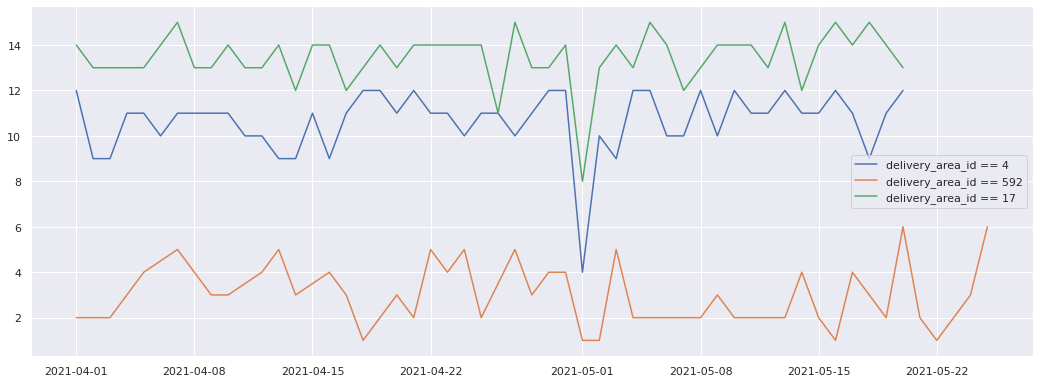

In [900]:
for delivery_area in [4, 592, 17]:
  plt.plot(
      orders[orders['delivery_area_id'] == delivery_area]['date'][:50],
      orders[orders['delivery_area_id'] == delivery_area]['orders_cnt'][:50],
      label=f'delivery_area_id == {delivery_area}'
  )
plt.legend()

### Utils

In [901]:
def get_test_data(X):
  X_train = X[X['date'] <= DATE_TEST_SPLIT]
  X_test = X[X['date'] > DATE_TEST_SPLIT]
  return X_train, X_test

In [902]:
def timeseries_train_test_split(X, y=None, test_size=0.3):
  X = X.sort_values(by='date')
  test_index = int(len(X) * (1 - test_size))
  X_train = X.iloc[:test_index]
  X_test = X.iloc[test_index:]
  if y is not None:
    y_train = y.iloc[:test_index]
    y_test = y.iloc[test_index:]
    return X_train, X_test, y_train, y_test
  return X_train, X_test

In [903]:
def save_all_dfs(X_train, X_val, X_test, name_suffix):
  X_train.to_csv(f'X_train_{name_suffix}.csv', index=False)
  X_val.to_csv(f'X_val_{name_suffix}.csv', index=False)
  X_test.to_csv(f'X_test_{name_suffix}.csv', index=False)
  print('Данные сохранены')

### Подготовка данных

#### Генерация признаков вида i дней назад/вперед

In [904]:
def get_prev_next_features(data):
  data = data.sort_values(by=['delivery_area_id', 'date'])

  for i in range(1, PREV_COLS_CNT + 1):
    data['prev_' + str(i)] = data.groupby(['delivery_area_id', 'date'], as_index=False).mean().shift(i).rolling(1).sum()['orders_cnt']

  data["future_1"] = data['orders_cnt'].copy()
  for i in range(2, NEXT_COLS_CNT + 1):
    data["future_" + str(i)] = data.groupby(['delivery_area_id', 'date'], as_index=False).mean().shift(-i+1).rolling(1).mean()['orders_cnt']

  return data

In [905]:
orders = get_prev_next_features(orders)

#### Train/val/test split

In [906]:
X_train, X_test = get_test_data(orders)
X_train, X_val = timeseries_train_test_split(X_train, test_size=0.2)

print(f'Train shape: {X_train.shape}')
print(f'Valid shape: {X_val.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (71230, 45)
Valid shape: (17808, 45)
Test shape: (8168, 45)


In [907]:
del orders
gc.collect()

156

#### Праздники и нерабочие дни

In [908]:
def get_holidays_features(data):
  data['is_holiday'] = data.progress_apply(lambda x: x['date'] in df_holidays['ds'].values, axis=1)
  data['is_dayoff'] = data.progress_apply(lambda x: x['date'] in dayoffs, axis=1)
  data['is_weekend'] = data.progress_apply(lambda x: x['dayofweek'] in [5, 6], axis=1)
  return data

In [909]:
X_train = get_holidays_features(X_train)
X_val = get_holidays_features(X_val)
X_test = get_holidays_features(X_test)

X_train.head()

100%|██████████| 8168/8168 [00:00<00:00, 62370.54it/s]


,delivery_area_id,date,orders_cnt,dttm,year,month,week,dayofweek,prev_1,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16,prev_17,prev_18,prev_19,prev_20,prev_21,prev_22,prev_23,prev_24,prev_25,prev_26,prev_27,prev_28,prev_29,prev_30,future_1,future_2,future_3,future_4,future_5,future_6,future_7,is_holiday,is_dayoff,is_weekend
0,0,2021-04-01,10,2021-04-01,2021,4,13,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,10.0,11.0,9.0,12.0,11.0,12.0,False,False,False
5383,23,2021-04-01,9,2021-04-01,2021,4,13,3,12.0,12.0,12.0,11.0,12.0,12.0,11.0,12.0,12.0,12.0,12.0,12.0,12.0,11.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,11.0,12.0,12.0,12.0,12.0,12.0,9,11.0,9.0,8.0,9.0,12.0,11.0,False,False,False
747,4,2021-04-01,12,2021-04-01,2021,4,13,3,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,11.0,12.0,12.0,12.0,12.0,12.0,11.0,12.0,13.0,12.0,12.0,12.0,12.0,11.0,12,9.0,9.0,11.0,11.0,10.0,11.0,False,False,False
12413,52,2021-04-01,2,2021-04-01,2021,4,13,3,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,2,2.0,4.0,5.0,2.0,1.0,4.0,False,False,False
5627,24,2021-04-01,11,2021-04-01,2021,4,13,3,13.0,14.0,13.0,14.0,14.0,13.0,14.0,14.0,13.0,13.0,14.0,13.0,14.0,13.0,14.0,14.0,14.0,13.0,13.0,13.0,12.0,14.0,13.0,12.0,14.0,13.0,13.0,13.0,14.0,12.0,11,9.0,12.0,10.0,12.0,12.0,12.0,False,False,False


#### Сколько дней до ближайших праздников

#### Сколько дней от последнего праздника

#### Нормировка на медиану

In [910]:
prev_cols = ["prev_" + str(i) for i in range(1, PREV_COLS_CNT + 1)][:7]  
X_train['1_week_median'] = X_train[prev_cols].median(1)
X_val['1_week_median'] = X_val[prev_cols].median(1)
X_test['1_week_median'] = X_test[prev_cols].median(1)

In [911]:
def norm_by_1_week_median(data):
  cols_to_norm = ["prev_" + str(i) for i in range(1, PREV_COLS_CNT + 1)] + ["future_" + str(i) for i in range(1, NEXT_COLS_CNT + 1)]
  for col in cols_to_norm:
    data[col] = data[col] / (data['1_week_median'] + EPS)
  return data

In [912]:
X_train = norm_by_1_week_median(X_train)
X_val = norm_by_1_week_median(X_val)
X_test = norm_by_1_week_median(X_test)

In [913]:
save_all_dfs(X_train, X_val, X_test, name_suffix='base_normalized')

Данные сохранены


#### Статистики

In [914]:
def get_aggregations(data, period, cols_range_left, cols_range_right):
  prev_cols = ["prev_" + str(i) for i in range(1, PREV_COLS_CNT + 1)][cols_range_left:cols_range_right]  

  data[f'{period}_median'] = data[prev_cols].median(1)
  data[f'{period}_mean'] = data[prev_cols].mean(1)
  data[f'{period}_std'] = data[prev_cols].std(1)
  data[f'{period}_min'] = data[prev_cols].min(1)
  data[f'{period}_max'] = data[prev_cols].max(1)    
  data[f'{period}_sum'] = data[prev_cols].sum(1)
  return data

In [915]:
# TODO: генерация фичей для разных периодов

#### Кластеризация рядов

### LightGBM

#### Инициализация

In [916]:
params = {
    'metric' : 'mape',
    'objective': 'mape',
    'learning_rate': 0.1,
    'seed': SEED,
    'max_depth': 10,
    'verbose' : -1,
    #'num_leaves': 31, # max number of leaves in one tree
    #'min_child_samples': 20, # minimal number of data in one leaf
    #'reg_alpha': 0.0,
    #'reg_lambda': 0.0,
    #'feature_fraction': 1.0,
    #'bagging_fraction': 0.85, # this will randomly select part of data without resampling
    #'bagging_freq': 0 # frequency for bagging 
}

In [917]:
class LGBMWeekModel(BaseEstimator):
    def __init__(self, params):
      self.params = params
      self.models = []
    
    def fit(self, data):
      for i in tqdm(range(7)):
        train_data = data.dropna(subset=[f'future_{i + 1}'])
        train_data = train_data.drop(train_data[train_data[f'future_{i + 1}'] == 0].index)
        train_data = lgb.Dataset(
            train_data.drop([f'future_{i}' for i in range(1, NEXT_COLS_CNT + 1)], axis=1),
            label=train_data[f'future_{i + 1}']
        )

        model = lgb.train(
          params=self.params,
          train_set=train_data,
          valid_sets=[train_data],
          num_boost_round=100, 
          verbose_eval=1000
        )
        self.models.append(model)
      return self
    
    def predict(self, data):
      preds_df = pd.DataFrame()
      for i in range(7):
        preds_df['pred_' + str(i)] = self.models[i].predict(data)
      return preds_df

In [918]:
model = LGBMWeekModel(params)
model.fit(X_train.drop(['date', 'dttm'], axis=1))

100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


LGBMWeekModel(params={'learning_rate': 0.1, 'max_depth': 10, 'metric': 'mape',
                      'objective': 'mape', 'seed': 2021, 'verbose': -1})

In [919]:
res = model.predict(X_val.drop(['date', 'dttm'], axis=1))

In [922]:
for i in range(7):
  print(mean_absolute_percentage_error(X_val[f'future_{i + 1}'], res['pred_' + str(i)]))

0.46831206352925875
0.1188839144645502
0.11574761405708561
0.12815340572635223
0.14001018617652145
0.1260768932260629
0.12992441533238733


In [927]:
X_test = X_test.dropna()

In [928]:
res = model.predict(X_test.drop(['date', 'dttm'], axis=1))
for i in range(7):
  print(mean_absolute_percentage_error(X_test[f'future_{i + 1}'], res['pred_' + str(i)]))

0.39488393740783495
0.3981269014595889
0.6332545505315701
0.8818389247802408
1.1392944286642857
1.321204226969923
1.5319474412410583


#### Подбор гиперпараметров

#### Валидация

#### Предсказание для теста

### Выводы